# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [67]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 1- Data Preparation

In [2]:
# data_hosp_rate_all = pd.read_csv(f'../output/measures/input_hospitalisation_rate_2019-01-01.csv.gz')
# data_hosp_rate_all.head()

In [3]:
# data_hosp_rate_sex = pd.read_csv(f'../output/measures/measure_hosp_rate.csv') 
# data_hosp_rate_sex

In [4]:
# data_hosp_rate_sex_binary = pd.read_csv(f'../output/measures/measure_hosp_rate_binary.csv') 
# data_hosp_rate_sex_binary

In [124]:
# data_hosp_rate = pd.read_csv(f'../output/measures/measure_hosp_rate.csv')
# data_hosp_rate_sex = pd.read_csv(f'../output/measures/measure_hosp_rate_sex.csv') 
# data_hosp_rate_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_age_cat.csv')
data_hosp_rate = pd.read_csv(f'../output/measures/measure_hosp_rate_binary.csv')
data_hosp_rate_sex = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_binary.csv') 
data_hosp_rate_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_age_cat_binary.csv')

data_hosp_rate_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_cat.csv')
data_hosp_rate_gp = pd.read_csv(f'../output/measures/measure_hosp_rate_gp.csv')

data_hosp_rate_sex.head()#.shape

,sex,admitted_binary,population,value,date
0,F,314.0,511,0.614481,2019-01-01
1,M,286.0,489,0.584867,2019-01-01
2,F,304.0,509,0.597250,2019-02-01
3,M,296.0,491,0.602851,2019-02-01
4,F,305.0,498,0.612450,2019-03-01


In [99]:
# data_hosp_rate = data_hosp_rate[data_hosp_rate['sgss_gp_cov_admitted_binary']==0]
# data_hosp_rate_sex = data_hosp_rate_sex[data_hosp_rate_sex['sgss_gp_cov_admitted_binary']==0]
# data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat['sgss_gp_cov_admitted_binary']==0]
# data_hosp_rate_cat = data_hosp_rate_cat[data_hosp_rate_cat['sgss_gp_cov_admitted_binary']==0]
# data_hosp_rate_gp = data_hosp_rate_gp[data_hosp_rate_gp['sgss_gp_cov_admitted_binary']==0]

# data_hosp_rate_sex.head()#.shape

In [100]:
# translate sex in data_hosp_rate_sex_age_cat
dict_sex = {'F': 'Female', 'M': 'Male'}
data_hosp_rate_sex = data_hosp_rate_sex.replace({"sex": dict_sex})

In [101]:
data_hosp_rate.describe(include='all')

,admitted_binary,population,value,date
count,38000.000000,38000.0,38000.000000,38000
unique,NaN,NaN,NaN,38
top,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,1000
mean,0.600000,1.0,0.600000,NaN
std,0.489904,0.0,0.489904,NaN
min,0.000000,1.0,0.000000,NaN
25%,0.000000,1.0,0.000000,NaN
50%,1.000000,1.0,1.000000,NaN
75%,1.000000,1.0,1.000000,NaN


In [102]:
data_hosp_rate_sex.describe(include='all')

,sex,admitted_binary,population,value,date
count,76,76.000000,76.00000,76.000000,76
unique,2,NaN,NaN,NaN,38
top,Female,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,2
mean,NaN,300.000000,500.00000,0.599903,NaN
std,NaN,16.193003,21.69301,0.015974,NaN
min,NaN,261.000000,445.00000,0.565558,NaN
25%,NaN,287.750000,487.00000,0.588089,NaN
50%,NaN,300.000000,500.00000,0.600000,NaN
75%,NaN,312.250000,513.00000,0.611850,NaN


In [103]:
data_hosp_rate_age_cat.describe(include='all')

,age_cat,admitted_binary,population,value,date
count,190,190.000000,190.000000,190.000000,190
unique,5,NaN,NaN,NaN,38
top,0-14,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,5
mean,NaN,120.000000,200.000000,0.599843,NaN
std,NaN,25.823372,41.794787,0.028057,NaN
min,NaN,58.000000,103.000000,0.518692,NaN
25%,NaN,115.000000,197.250000,0.581333,NaN
50%,NaN,128.000000,215.000000,0.599078,NaN
75%,NaN,137.000000,227.000000,0.616681,NaN


In [104]:
data_hosp_rate_cat.describe(include='all')

,admitted_cat,admitted,population,value,date
count,418,456.000000,456.000000,456.000000,456
unique,11,NaN,NaN,NaN,38
top,A39,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,12
mean,NaN,276.337719,83.333333,3.337414,NaN
std,NaN,615.586328,186.290293,0.645264,NaN
min,NaN,15.000000,7.000000,1.062500,NaN
25%,NaN,71.750000,23.000000,2.932759,NaN
50%,NaN,96.000000,29.000000,3.285714,NaN
75%,NaN,121.250000,35.000000,3.752155,NaN


In [105]:
data_hosp_rate_gp.describe(include='all')

,gp_cons_admitted_binary,admitted,population,value,date
count,76.000000,76.000000,76.0,76.000000,76
unique,NaN,NaN,NaN,NaN,38
top,NaN,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,NaN,2
mean,0.500000,1658.026316,500.0,3.316053,NaN
std,0.503322,67.429563,0.0,0.134859,NaN
min,0.000000,1499.000000,500.0,2.998000,NaN
25%,0.000000,1618.500000,500.0,3.237000,NaN
50%,0.500000,1658.000000,500.0,3.316000,NaN
75%,1.000000,1707.000000,500.0,3.414000,NaN


## 2- Hospital admission rate

In [106]:
data_hosp_rate.head()

,admitted_binary,population,value,date
0,0.0,1,0.0,2019-01-01
1,1.0,1,1.0,2019-01-01
2,0.0,1,0.0,2019-01-01
3,0.0,1,0.0,2019-01-01
4,1.0,1,1.0,2019-01-01


In [14]:
# data_hosp_rate['date'] = data_hosp_rate['date'].astype('datetime64[ns]') 

In [15]:
data_hosp_rate_groupby_date = data_hosp_rate.groupby([data_hosp_rate['date']]).mean().reset_index()
data_hosp_rate_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01-01,0.6,1.0,0.6
1,2019-02-01,0.6,1.0,0.6
2,2019-03-01,0.6,1.0,0.6
3,2019-04-01,0.6,1.0,0.6
4,2019-05-01,0.6,1.0,0.6


In [16]:
# # data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date.index

data_hosp_rate_groupby_date['date'] = pd.to_datetime(data_hosp_rate_groupby_date['date']).dt.to_period('m')

data_hosp_rate_groupby_date['date']= data_hosp_rate_groupby_date['date'].astype(str)

# data_hosp_rate_groupby_date['date'] = pd.to_datetime(data_hosp_rate_groupby_date['date'])

# data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date['date'].dt.date()

# # pd.to_datetime(df['DATE'],format='%m%Y', errors='coerce')

# data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date['date'].dt.to_timestamp('%Y-%m')

# # data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date['date'].dt.timestamp

# # data_hosp_rate_groupby_date['date'] = pd.to_datetime(data_hosp_rate_groupby_date['date'])

# # data_hosp_rate_groupby_date.index = data_hosp_rate_groupby_date.date

# # data_hosp_rate_groupby_date = data_hosp_rate_groupby_date.drop(columns=['date'])

data_hosp_rate_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,0.6,1.0,0.6
1,2019-02,0.6,1.0,0.6
2,2019-03,0.6,1.0,0.6
3,2019-04,0.6,1.0,0.6
4,2019-05,0.6,1.0,0.6


In [17]:
# # nullify some values to check lineplot with missing values
# data_hosp_rate_groupby_date['value'] = data_hosp_rate_groupby_date['value'].where(data_hosp_rate_groupby_date['value'].between(3.3,100))

# data_hosp_rate_groupby_date.head()

In [18]:
data_hosp_rate_groupby_date['value'] = data_hosp_rate_groupby_date['value']*1000

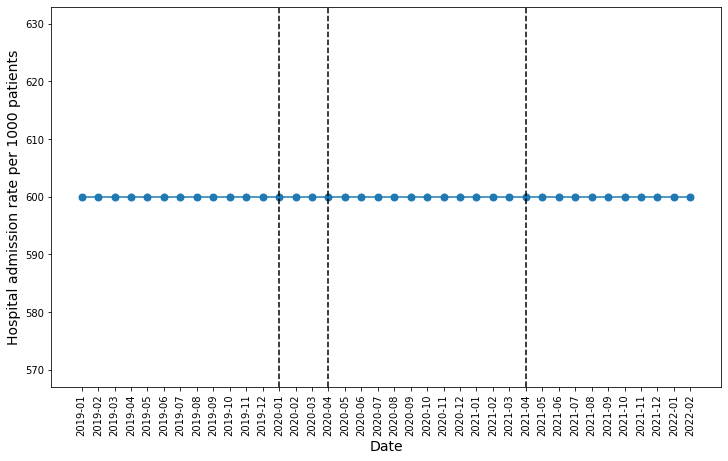

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# sns.lineplot(y=data_hosp_rate_groupby_date['value'], x=data_hosp_rate_groupby_date.index, ax=ax1, linestyle='-', marker='o', markersize=7)

ax1.plot(data_hosp_rate_groupby_date['date'], data_hosp_rate_groupby_date['value'], linestyle='-', marker='o', markersize=7)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_1000_patient.jpg')
plt.show()

## 3- Hospital admission with sex

In [21]:
data_hosp_rate_sex

,sex,admitted_binary,population,value,date
0,Female,314.0,511,0.614481,2019-01-01
1,Male,286.0,489,0.584867,2019-01-01
2,Female,304.0,509,0.597250,2019-02-01
3,Male,296.0,491,0.602851,2019-02-01
4,Female,305.0,498,0.612450,2019-03-01
...,...,...,...,...,...
71,Male,311.0,489,0.635992,2021-12-01
72,Female,280.0,456,0.614035,2022-01-01
73,Male,320.0,544,0.588235,2022-01-01
74,Female,315.0,504,0.625000,2022-02-01


In [22]:
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_sex.groupby(['date', 'sex']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_cat_sex_groupby_sex.reset_index()
data_hosp_rate_cat_sex_groupby_sex.columns = ['date', 'sex', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01-01,Female,0.614481,0.614481,0.614481,0.614481
1,2019-01-01,Male,0.584867,0.584867,0.584867,0.584867
2,2019-02-01,Female,0.597250,0.597250,0.597250,0.597250
3,2019-02-01,Male,0.602851,0.602851,0.602851,0.602851
4,2019-03-01,Female,0.612450,0.612450,0.612450,0.612450


In [23]:
# data_hosp_rate_cat_sex_groupby_sex.date = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex.date)

# data_hosp_rate_cat_sex_groupby_sex.date = data_hosp_rate_cat_sex_groupby_sex.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date'])

data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date']).dt.to_period('m')

data_hosp_rate_cat_sex_groupby_sex['date']= data_hosp_rate_cat_sex_groupby_sex['date'].astype(str)

data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01,Female,0.614481,0.614481,0.614481,0.614481
1,2019-01,Male,0.584867,0.584867,0.584867,0.584867
2,2019-02,Female,0.597250,0.597250,0.597250,0.597250
3,2019-02,Male,0.602851,0.602851,0.602851,0.602851
4,2019-03,Female,0.612450,0.612450,0.612450,0.612450


In [24]:
data_hosp_rate_cat_sex_groupby_sex['value_mean'] = data_hosp_rate_cat_sex_groupby_sex['value_mean']*1000

In [25]:
# data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date'])

# # data_hosp_rate_cat_sex_groupby_sex.date = data_hosp_rate_cat_sex_groupby_sex.date.dt.strftime('%Y-%m')

# # # data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date']).dt.to_period('m')

# # data_hosp_rate_cat_sex_groupby_sex['date']= data_hosp_rate_cat_sex_groupby_sex['date'].astype(str)

In [26]:
# data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date']).dt.strftime('%Y-%m')

In [27]:
# fig, ax = plt.subplots(figsize=(12, 7))

# # colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}
# colors = {'Male':'orange', 'Female':'purple'}

# grouped = data_hosp_rate_cat_sex_groupby_sex.groupby('sex')
# for key, group in grouped:
#     group.plot(ax=ax, kind='line', x='date', y='value_mean', label=key, color=colors[key])

# # ax.axvline(x="2020-01", color='black', ls='--', lw=1.5)  
# # plt.vlines(x="2020-01", ymin=0, ymax=1, colors='green', ls=':', lw=2)

# plt.xticks(rotation=90)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# # plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# # plt.legend([],[], frameon=False)
# # plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# # plt.axvline(x="2020-04-01", color='black', ls='--', lw=1.5)
# # plt.axvline(x="2021-04-01", color='black', ls='--', lw=1.5)
# # plt.vlines(x=datetime(2020, 1, 1), ymin=0, ymax=5, colors='green')
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
# plt.show()

In [28]:
# fig, ax = plt.subplots(figsize=(12, 7))

# # colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}
# colors = {'Male':'orange', 'Female':'purple'}

# plt.plot(data_hosp_rate_cat_sex_groupby_sex['date'], data_hosp_rate_cat_sex_groupby_sex['value_mean'], c= data_hosp_rate_cat_sex_groupby_sex['sex'].map(colors), ax=ax, kind='line')#,
#             # cmap='viridis


# # grouped = data_hosp_rate_cat_sex_groupby_sex.groupby('sex')
# # for key, group in grouped:
# #     group.plot(ax=ax, kind='line', x='date', y='value_mean', label=key, color=colors[key])

# # # plt.axis.set_tick_params(rotation=90)
# # plt.xticks(rotation=90)
# # # plt.grid()
# # plt.xlabel('Date', fontsize=14)
# # plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# # # plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# # # plt.legend([],[], frameon=False)
# # plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# # plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
# # plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# # # plt.tight_layout()
# # plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')

# plt.show()

In [29]:
# fig, ax1 = plt.subplots(figsize=(12, 7))

# # sns.lineplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", ax=ax1)

# # colors = {'Male':'red', 'Female':'green'}
# # colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}

# ax1.plot(data_hosp_rate_cat_sex_groupby_sex['date'], data_hosp_rate_cat_sex_groupby_sex['value_mean'])#, c=code)#, cmap='jet', transform=ccrs.PlateCarree())#data_hosp_rate_cat_sex_groupby_sex['continent'].map(colors))#, linestyle='-', marker='o', markersize=7)

# # # plt.axis.set_tick_params(rotation=90)
# # plt.xticks(rotation=90)
# # # plt.grid()
# # plt.xlabel('Date', fontsize=14)
# # plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# # # plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# # # plt.legend([],[], frameon=False)
# # plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# # plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
# # plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# # # plt.tight_layout()
# # plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
# plt.show()

In [30]:
# # nullify some values to check lineplot with missing values
# data_hosp_rate_cat_sex_groupby_sex['value_mean'] = data_hosp_rate_cat_sex_groupby_sex['value_mean'].where(data_hosp_rate_cat_sex_groupby_sex['value_mean'].between(3300,10000))

# data_hosp_rate_cat_sex_groupby_sex.head()

In [31]:
data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date'])

data_hosp_rate_cat_sex_groupby_sex.date = data_hosp_rate_cat_sex_groupby_sex.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date']).dt.to_period('m')

# data_hosp_rate_cat_sex_groupby_sex['date'] = data_hosp_rate_cat_sex_groupby_sex['date'].astype(str)

data_hosp_rate_cat_sex_groupby_sex['date']

0     2019-01
1     2019-01
2     2019-02
3     2019-02
4     2019-03
       ...   
71    2021-12
72    2022-01
73    2022-01
74    2022-02
75    2022-02
Name: date, Length: 76, dtype: object

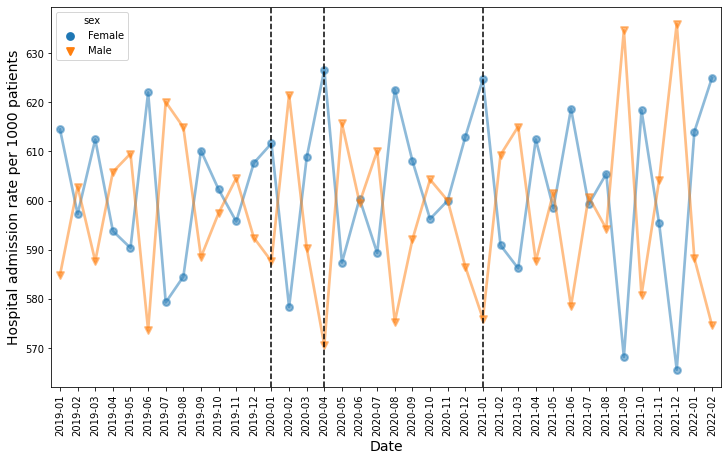

In [32]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
plt.show()

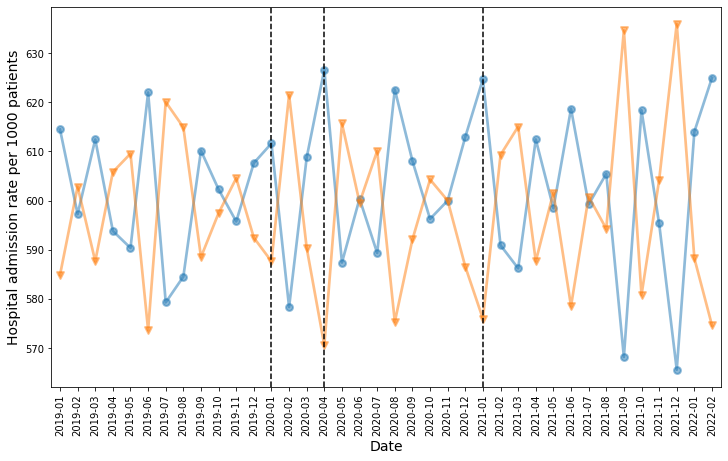

In [33]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission with age_cat

In [68]:
data_hosp_rate_age_cat

,age_cat,admitted_binary,population,value,date
0,0-14,80.0,130,0.615385,2019-01-01
1,15-34,127.0,214,0.593458,2019-01-01
2,35-54,131.0,220,0.595455,2019-01-01
3,55-74,132.0,217,0.608295,2019-01-01
4,75+,130.0,219,0.593607,2019-01-01
...,...,...,...,...,...
185,0-14,73.0,115,0.634783,2022-02-01
186,15-34,126.0,216,0.583333,2022-02-01
187,35-54,124.0,222,0.558559,2022-02-01
188,55-74,154.0,238,0.647059,2022-02-01


In [69]:
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != 0]
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != '0']
data_hosp_rate_age_cat

,age_cat,admitted_binary,population,value,date
0,0-14,80.0,130,0.615385,2019-01-01
1,15-34,127.0,214,0.593458,2019-01-01
2,35-54,131.0,220,0.595455,2019-01-01
3,55-74,132.0,217,0.608295,2019-01-01
4,75+,130.0,219,0.593607,2019-01-01
...,...,...,...,...,...
185,0-14,73.0,115,0.634783,2022-02-01
186,15-34,126.0,216,0.583333,2022-02-01
187,35-54,124.0,222,0.558559,2022-02-01
188,55-74,154.0,238,0.647059,2022-02-01


In [70]:
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_age_cat.groupby(['date', 'age_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_cat_age_cat_groupby_age.reset_index()
data_hosp_rate_cat_age_cat_groupby_age.columns = ['date', 'age', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01-01,0-14,0.615385,0.615385,0.615385,0.615385
1,2019-01-01,15-34,0.593458,0.593458,0.593458,0.593458
2,2019-01-01,35-54,0.595455,0.595455,0.595455,0.595455
3,2019-01-01,55-74,0.608295,0.608295,0.608295,0.608295
4,2019-01-01,75+,0.593607,0.593607,0.593607,0.593607


In [71]:
data_hosp_rate_cat_age_cat_groupby_age.date = pd.to_datetime(data_hosp_rate_cat_age_cat_groupby_age.date)

data_hosp_rate_cat_age_cat_groupby_age.date = data_hosp_rate_cat_age_cat_groupby_age.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01,0-14,0.615385,0.615385,0.615385,0.615385
1,2019-01,15-34,0.593458,0.593458,0.593458,0.593458
2,2019-01,35-54,0.595455,0.595455,0.595455,0.595455
3,2019-01,55-74,0.608295,0.608295,0.608295,0.608295
4,2019-01,75+,0.593607,0.593607,0.593607,0.593607


In [38]:
data_hosp_rate_cat_age_cat_groupby_age['value_mean'] = data_hosp_rate_cat_age_cat_groupby_age['value_mean']*1000

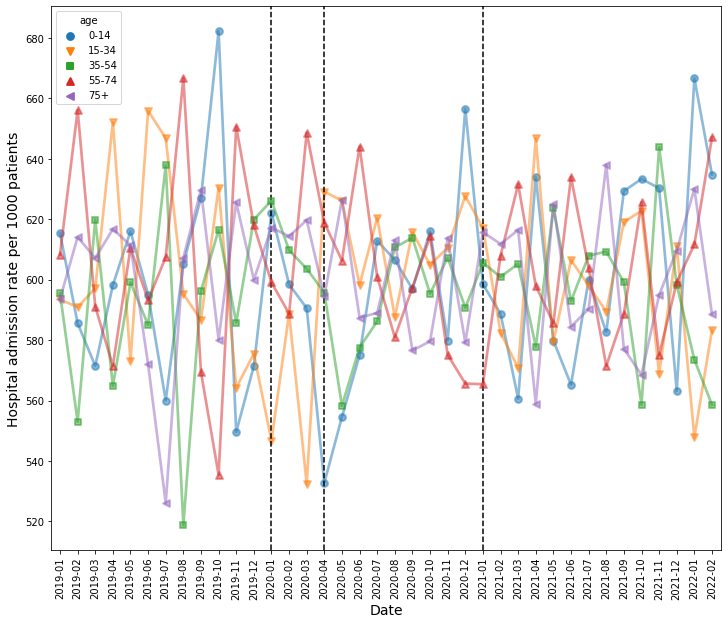

In [39]:
plt.figure(figsize=(12,10))

g = sns.pointplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", markers=['o', 'v', 's', '^', '<'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient.jpg')
plt.show()

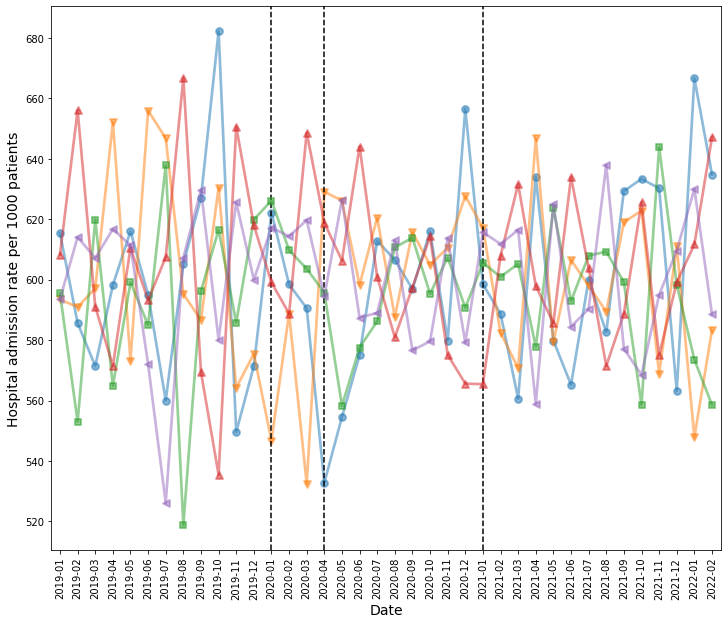

In [40]:
plt.figure(figsize=(12,10))

g = sns.pointplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", markers=['o', 'v', 's', '^', '<'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient_nolegend.jpg')
plt.show()

## 5- Hospital admission with admission category

In [193]:
print(f'shape of data_hosp_rate_cat: {data_hosp_rate_cat.shape}\n')
data_hosp_rate_cat

shape of data_hosp_rate_cat: (456, 5)



,admitted_cat,admitted,population,value,date
0,NaN,2221.0,700,3.172857,2019-01-01
1,A39,72.0,27,2.666667,2019-01-01
2,A40,75.0,23,3.260870,2019-01-01
3,A41,69.0,15,4.600000,2019-01-01
4,B95,44.0,13,3.384615,2019-01-01
...,...,...,...,...,...
451,J13,108.0,23,4.695652,2022-02-01
452,K05,129.0,31,4.161290,2022-02-01
453,L01,71.0,29,2.448276,2022-02-01
454,M00,111.0,28,3.964286,2022-02-01


In [194]:
data_hosp_rate_cat = data_hosp_rate_cat.replace(np.nan, 'NA', regex=True)
data_hosp_rate_cat

,admitted_cat,admitted,population,value,date
0,NA,2221.0,700,3.172857,2019-01-01
1,A39,72.0,27,2.666667,2019-01-01
2,A40,75.0,23,3.260870,2019-01-01
3,A41,69.0,15,4.600000,2019-01-01
4,B95,44.0,13,3.384615,2019-01-01
...,...,...,...,...,...
451,J13,108.0,23,4.695652,2022-02-01
452,K05,129.0,31,4.161290,2022-02-01
453,L01,71.0,29,2.448276,2022-02-01
454,M00,111.0,28,3.964286,2022-02-01


In [136]:
# data_hosp_rate_cat.groupby([data_hosp_rate_cat['date']]).sum().reset_index().population

In [195]:
data_hosp_rate_cat_groupby_date_admitted_cat = data_hosp_rate_cat.groupby(['date', 'admitted_cat'], as_index=False).sum()
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted,population,value
0,2019-01-01,A39,72.0,27,2.666667
1,2019-01-01,A40,75.0,23,3.260870
2,2019-01-01,A41,69.0,15,4.600000
3,2019-01-01,B95,44.0,13,3.384615
4,2019-01-01,G00,127.0,34,3.735294
...,...,...,...,...,...
451,2022-02-01,K05,129.0,31,4.161290
452,2022-02-01,L01,71.0,29,2.448276
453,2022-02-01,M00,111.0,28,3.964286
454,2022-02-01,N10,104.0,33,3.151515


In [196]:
data_hosp_rate_cat_groupby_date_admitted_cat.admitted_cat.value_counts()

A39    38
A40    38
A41    38
B95    38
G00    38
H60    38
J13    38
K05    38
L01    38
M00    38
N10    38
NA     38
Name: admitted_cat, dtype: int64

In [197]:
data_hosp_rate_cat_groupby_date_admitted_cat['population_sum'] = data_hosp_rate_cat_groupby_date_admitted_cat['population'].groupby(data_hosp_rate_cat_groupby_date_admitted_cat['date']).transform('sum')
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted,population,value,population_sum
0,2019-01-01,A39,72.0,27,2.666667,1000
1,2019-01-01,A40,75.0,23,3.260870,1000
2,2019-01-01,A41,69.0,15,4.600000,1000
3,2019-01-01,B95,44.0,13,3.384615,1000
4,2019-01-01,G00,127.0,34,3.735294,1000
...,...,...,...,...,...,...
451,2022-02-01,K05,129.0,31,4.161290,1000
452,2022-02-01,L01,71.0,29,2.448276,1000
453,2022-02-01,M00,111.0,28,3.964286,1000
454,2022-02-01,N10,104.0,33,3.151515,1000


In [198]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated'] = data_hosp_rate_cat_groupby_date_admitted_cat['admitted']/data_hosp_rate_cat_groupby_date_admitted_cat['population_sum']
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted,population,value,population_sum,value_calculated
0,2019-01-01,A39,72.0,27,2.666667,1000,0.072
1,2019-01-01,A40,75.0,23,3.260870,1000,0.075
2,2019-01-01,A41,69.0,15,4.600000,1000,0.069
3,2019-01-01,B95,44.0,13,3.384615,1000,0.044
4,2019-01-01,G00,127.0,34,3.735294,1000,0.127
...,...,...,...,...,...,...,...
451,2022-02-01,K05,129.0,31,4.161290,1000,0.129
452,2022-02-01,L01,71.0,29,2.448276,1000,0.071
453,2022-02-01,M00,111.0,28,3.964286,1000,0.111
454,2022-02-01,N10,104.0,33,3.151515,1000,0.104


In [199]:
data_hosp_rate_cat_groupby_date_admitted_cat = data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat.admitted_cat != 'NA']
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted,population,value,population_sum,value_calculated
0,2019-01-01,A39,72.0,27,2.666667,1000,0.072
1,2019-01-01,A40,75.0,23,3.260870,1000,0.075
2,2019-01-01,A41,69.0,15,4.600000,1000,0.069
3,2019-01-01,B95,44.0,13,3.384615,1000,0.044
4,2019-01-01,G00,127.0,34,3.735294,1000,0.127
...,...,...,...,...,...,...,...
450,2022-02-01,J13,108.0,23,4.695652,1000,0.108
451,2022-02-01,K05,129.0,31,4.161290,1000,0.129
452,2022-02-01,L01,71.0,29,2.448276,1000,0.071
453,2022-02-01,M00,111.0,28,3.964286,1000,0.111


In [200]:
# data_hosp_rate_cat[data_hosp_rate_cat["admitted_cat"].str.contains("A40")]
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('A40'), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('A41'), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('N39'), 'admitted_cat'] = 'UTI-related'
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted,population,value,population_sum,value_calculated
0,2019-01-01,A39,72.0,27,2.666667,1000,0.072
1,2019-01-01,Sepsis,75.0,23,3.260870,1000,0.075
2,2019-01-01,Sepsis,69.0,15,4.600000,1000,0.069
3,2019-01-01,B95,44.0,13,3.384615,1000,0.044
4,2019-01-01,G00,127.0,34,3.735294,1000,0.127
...,...,...,...,...,...,...,...
450,2022-02-01,J13,108.0,23,4.695652,1000,0.108
451,2022-02-01,K05,129.0,31,4.161290,1000,0.129
452,2022-02-01,L01,71.0,29,2.448276,1000,0.071
453,2022-02-01,M00,111.0,28,3.964286,1000,0.111


In [201]:
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('A'), 'admitted_cat'] = 'A'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('B'), 'admitted_cat'] = 'B'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('G'), 'admitted_cat'] = 'G'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('H'), 'admitted_cat'] = 'H'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('J'), 'admitted_cat'] = 'J'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('K'), 'admitted_cat'] = 'K'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('L'), 'admitted_cat'] = 'L'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('M'), 'admitted_cat'] = 'M'
data_hosp_rate_cat_groupby_date_admitted_cat.loc[data_hosp_rate_cat_groupby_date_admitted_cat['admitted_cat'].str.contains('N'), 'admitted_cat'] = 'N'

data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted,population,value,population_sum,value_calculated
0,2019-01-01,A,72.0,27,2.666667,1000,0.072
1,2019-01-01,Sepsis,75.0,23,3.260870,1000,0.075
2,2019-01-01,Sepsis,69.0,15,4.600000,1000,0.069
3,2019-01-01,B,44.0,13,3.384615,1000,0.044
4,2019-01-01,G,127.0,34,3.735294,1000,0.127
...,...,...,...,...,...,...,...
450,2022-02-01,J,108.0,23,4.695652,1000,0.108
451,2022-02-01,K,129.0,31,4.161290,1000,0.129
452,2022-02-01,L,71.0,29,2.448276,1000,0.071
453,2022-02-01,M,111.0,28,3.964286,1000,0.111


In [202]:
data_hosp_rate_cat_groupby_date_admitted_cat.date = pd.to_datetime(data_hosp_rate_cat_groupby_date_admitted_cat.date)

data_hosp_rate_cat_groupby_date_admitted_cat.date = data_hosp_rate_cat_groupby_date_admitted_cat.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_groupby_date_admitted_cat#.head()

,date,admitted_cat,admitted,population,value,population_sum,value_calculated
0,2019-01,A,72.0,27,2.666667,1000,0.072
1,2019-01,Sepsis,75.0,23,3.260870,1000,0.075
2,2019-01,Sepsis,69.0,15,4.600000,1000,0.069
3,2019-01,B,44.0,13,3.384615,1000,0.044
4,2019-01,G,127.0,34,3.735294,1000,0.127
...,...,...,...,...,...,...,...
450,2022-02,J,108.0,23,4.695652,1000,0.108
451,2022-02,K,129.0,31,4.161290,1000,0.129
452,2022-02,L,71.0,29,2.448276,1000,0.071
453,2022-02,M,111.0,28,3.964286,1000,0.111


In [203]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated']*1000

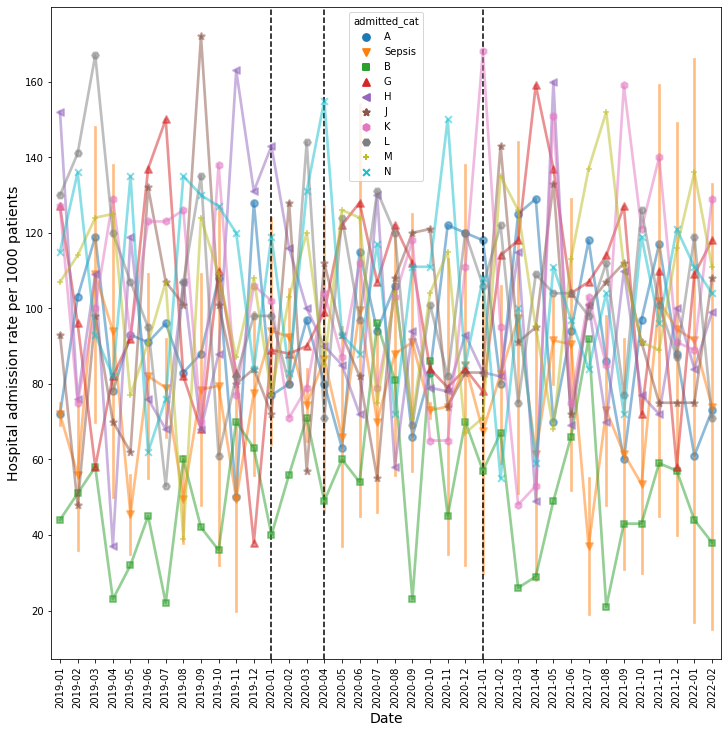

In [204]:
plt.figure(figsize=(12,12))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
plt.show()

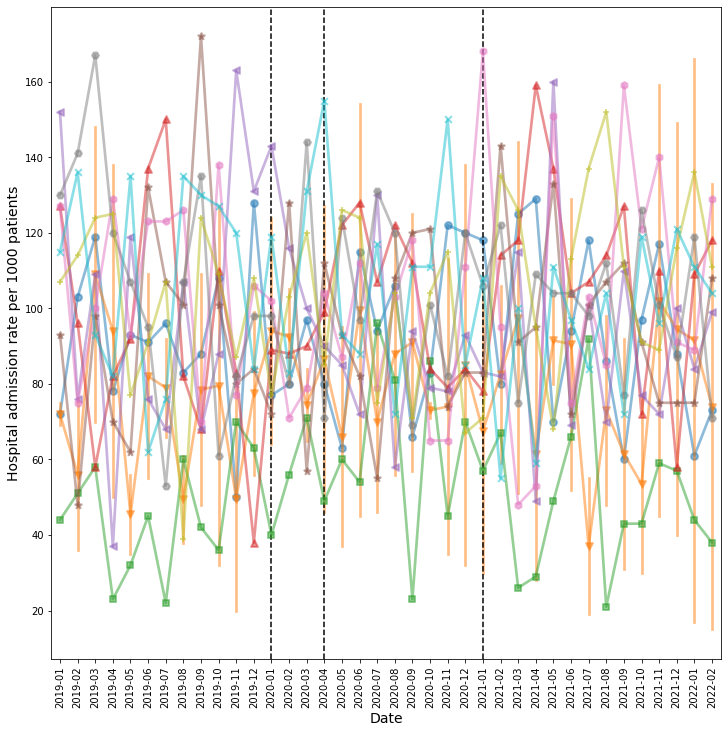

In [205]:
plt.figure(figsize=(12,12))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
plt.show()

In [120]:
# #calculate value by summing up the population and diving admitted count
# data_hosp_rate_cat['value_calculated'] = data_hosp_rate_cat['admitted']/data_hosp_rate_cat.groupby([data_hosp_rate_cat['date']]).sum().reset_index().population
# data_hosp_rate_cat

In [150]:
# data_hosp_rate_cat = data_hosp_rate_cat[data_hosp_rate_cat['admitted_cat'].notna()]
# data_hosp_rate_cat

In [151]:
# # data_hosp_rate_cat[data_hosp_rate_cat["admitted_cat"].str.contains("A40")]
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A40'), 'admitted_cat'] = 'Sepsis'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A41'), 'admitted_cat'] = 'Sepsis'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N39'), 'admitted_cat'] = 'UTI-related'
# data_hosp_rate_cat

In [152]:
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A'), 'admitted_cat'] = 'A'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('B'), 'admitted_cat'] = 'B'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('G'), 'admitted_cat'] = 'G'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('H'), 'admitted_cat'] = 'H'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('J'), 'admitted_cat'] = 'J'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('K'), 'admitted_cat'] = 'K'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('L'), 'admitted_cat'] = 'L'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('M'), 'admitted_cat'] = 'M'
# data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N'), 'admitted_cat'] = 'N'

# data_hosp_rate_cat

In [153]:
# data_hosp_rate_cat_groupby_date = data_hosp_rate_cat.groupby(['date', 'admitted_cat']).agg({'value_calculated': ['mean', 'min', 'max', 'sum', 'count']})
# data_hosp_rate_cat_groupby_date = data_hosp_rate_cat_groupby_date.reset_index()
# # data_hosp_rate_cat_groupby_date.columns = ['date', 'admitted_cat', 'value_mean', 'value_min', 'value_max', 'value_sum', 'value_count']
# data_hosp_rate_cat_groupby_date.columns = ['date', 'admitted_cat', 'value_calculated_mean', 'value_calculated_min', 'value_calculated_max', 'value_calculated_sum', 'value_calculated_count']
# data_hosp_rate_cat_groupby_date

In [85]:
# # data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date.groupby([data_hosp_rate_cat_groupby_date['admitted_cat']]).sum()
# # data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date_hosp_al.reset_index()
# # data_hosp_rate_cat_groupby_date_hosp_al.head()

# data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date.groupby(['date', 'admitted_cat']).agg({'value': ['mean', 'min', 'max', 'sum', 'count']})
# # data_hosp_rate_cat_groupby_date_hosp_al = data_hosp_rate_cat_groupby_date_hosp_al.reset_index()
# # data_hosp_rate_cat_groupby_date_hosp_al.columns = ['date', 'admitted_cat', 'value_mean', 'value_min', 'value_max', 'value_sum', 'value_count']
# data_hosp_rate_cat_groupby_date_hosp_al

In [154]:
# data_hosp_rate_cat_groupby_date.date = pd.to_datetime(data_hosp_rate_cat_groupby_date.date)

# data_hosp_rate_cat_groupby_date.date = data_hosp_rate_cat_groupby_date.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_groupby_date#.head()

In [155]:
# data_hosp_rate_cat_groupby_date['value_calculated_mean'] = data_hosp_rate_cat_groupby_date['value_calculated_mean']*1000

In [156]:
# plt.figure(figsize=(12,12))

# g = sns.pointplot(data=data_hosp_rate_cat_groupby_date, y="value_calculated_mean", x="date", hue="admitted_cat", 
#                 markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
#                 plot_kws=dict(alpha=0.5))

# plt.setp(g.collections, alpha=.5) #alpha for markers
# plt.setp(g.lines, alpha=.5) #alpha for line

# g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
# g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
# g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

# plt.xticks(rotation=90)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# # plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# # plt.legend([],[], frameon=False)
# # ax.set_xticklabels([])
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
# plt.show()

In [157]:
# plt.figure(figsize=(12,12))

# g = sns.pointplot(data=data_hosp_rate_cat_groupby_date, y="value_mean", x="date", hue="admitted_cat", 
#                 markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
#                 plot_kws=dict(alpha=0.5))

# plt.setp(g.collections, alpha=.5) #alpha for markers
# plt.setp(g.lines, alpha=.5) #alpha for line

# g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
# g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
# g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

# plt.xticks(rotation=90)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# # plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# # ax.set_xticklabels([])
# # plt.tight_layout()
# plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
# plt.show()

## 4- Hospital admission rate with GP consultation

In [159]:
data_hosp_rate_gp

,gp_cons_admitted_binary,admitted,population,value,date
0,0,1671.0,500,3.342,2019-01-01
1,1,1661.0,500,3.322,2019-01-01
2,0,1695.0,500,3.390,2019-02-01
3,1,1766.0,500,3.532,2019-02-01
4,0,1621.0,500,3.242,2019-03-01
...,...,...,...,...,...
71,1,1710.0,500,3.420,2021-12-01
72,0,1563.0,500,3.126,2022-01-01
73,1,1637.0,500,3.274,2022-01-01
74,0,1655.0,500,3.310,2022-02-01


In [170]:
data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].mean()#sum()
# data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum()
data_hosp_rate_gp_groupby_date['value_sum'] = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum().value #data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum()
data_hosp_rate_gp_groupby_date

,date,gp_cons_admitted_binary,value,value_sum
0,2019-01-01,0,3.342,3.342
1,2019-01-01,1,3.322,3.322
2,2019-02-01,0,3.390,3.390
3,2019-02-01,1,3.532,3.532
4,2019-03-01,0,3.242,3.242
...,...,...,...,...
71,2021-12-01,1,3.420,3.420
72,2022-01-01,0,3.126,3.126
73,2022-01-01,1,3.274,3.274
74,2022-02-01,0,3.310,3.310


In [98]:
# data_hosp_rate_sex_age_cat_gp.groupby([data_hosp_rate_sex_age_cat['date']]).sum()

In [99]:
# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_gp.groupby(['date', 'gp_cons_admitted_binary']).agg({'value': ['mean', 'min', 'max', 'sum']})
# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp_groupby_date.reset_index()
# data_hosp_rate_sex_age_cat_gp_groupby_date.columns = ['date', 'gp_cons_admitted_binary', 'value_mean', 'value_min', 'value_max', 'value_sum']
# data_hosp_rate_sex_age_cat_gp_groupby_date

In [171]:
data_hosp_rate_gp_groupby_date.date = pd.to_datetime(data_hosp_rate_gp_groupby_date.date)

data_hosp_rate_gp_groupby_date.date = data_hosp_rate_gp_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_gp_groupby_date.head()

,date,gp_cons_admitted_binary,value,value_sum
0,2019-01,0,3.342,3.342
1,2019-01,1,3.322,3.322
2,2019-02,0,3.390,3.390
3,2019-02,1,3.532,3.532
4,2019-03,0,3.242,3.242


In [101]:
data_hosp_rate_gp_groupby_date['value'] = data_hosp_rate_gp_groupby_date['value']*1000
data_hosp_rate_gp_groupby_date['value_sum'] = data_hosp_rate_gp_groupby_date['value_sum']*1000

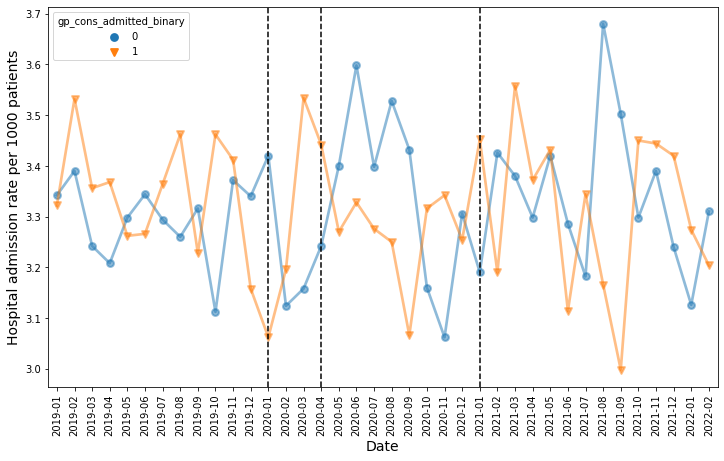

In [190]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient.jpg')
plt.show()

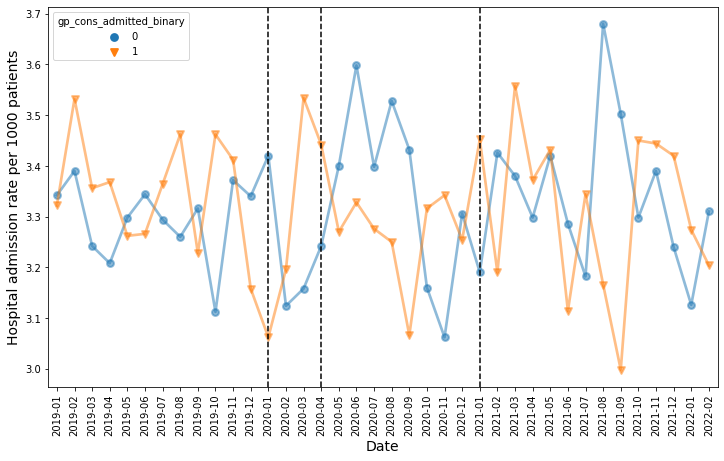

In [191]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value_sum", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_sum.jpg')
plt.show()

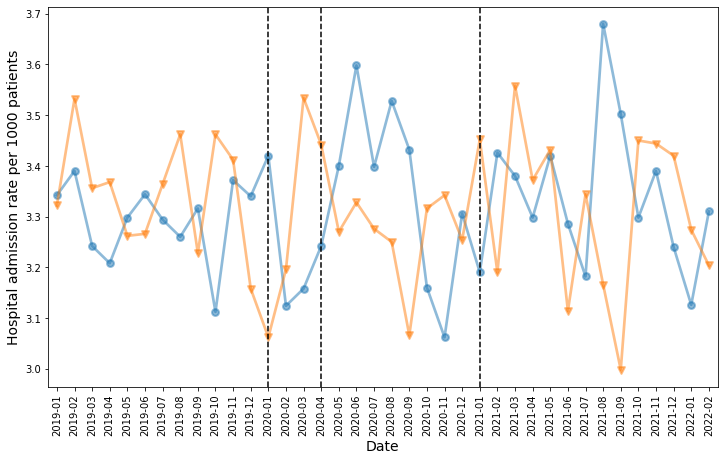

In [187]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_nolegend.jpg')
plt.show()

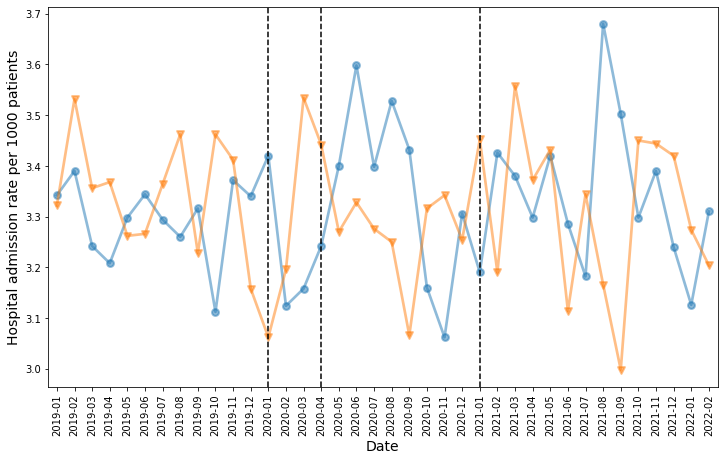

In [192]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value_sum", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_sum_nolegend.jpg')
plt.show()